<a href="https://colab.research.google.com/github/MarioRMReis/Sentinel_Images/blob/main/Sentinel_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Run me first
Run this cell to install packages if missing.
Run the next cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

Run colab locally.

 - pip install jupyter_http_over_ws  
 - jupyter serverextension enable --py jupyter_http_over_ws
 - jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [ ]:
!pip install pykml
!pip install fastkml
!pip install geopandas
!pip intall fiona
!pip install ogr
!pip install fastkml
!pip install geemap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import ee
# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AWtgzh7NDovCUtYLmULgNjBVdQdzghCJo3ufyMnDivalEODCySgjSSsJrYY

Successfully saved authorization token.


### Datasets and Python modules

- COPERNICUS/S1_GRD  
    - Sentinel-1 ground range detected images converted to decibels

- COPERNICUS/S2
    - Sentinel-2

The following cell imports some python modules which we will be using as we go along,  and also enables inline graphics.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import geemap
import os
import cv2
import requests
import math
from pykml import parser
%matplotlib inline

# Parameters for the image request

In [57]:
C_drivePath = 'C:/Users/mario/Documents/Mario/'
folder_dataset = C_drivePath + 'Sentinel/dataset'
starting_date = '2017-01-01'
ending_date = '2023-12-31'
nimgs = 2190


Let's start work by grabbing a spatial subset of a Sentinel-1 image from the archive. We'll define an region of interest (AOI) as the long-lat corners of a rectangle over the Frankfurt Airport. A convenient way to do this is with the [geojson.io](http://geojson.io/#map=2/20.0/0.0) website, from which we can cut and paste the corresponding GeoJSON object description.

Open KML and convert into list of areas of interst

In [72]:
aoi = []
aoi_names = []
kml_files = os.listdir(C_drivePath + 'Sentinel/roi/')

for kml in kml_files:
  with open(C_drivePath + 'Sentinel/' + kml, 'r') as f:
    root = parser.parse(f).getroot()
  namespace = {"kml": 'http://www.opengis.net/kml/2.2'}
  pms = root.xpath(".//kml:Placemark[.//kml:Polygon]", namespaces=namespace)
  roi_string = []
  for p in pms:
    if hasattr(p, 'MultiGeometry'):
      for poly in p.MultiGeometry.Polygon:
        roi_string.append(poly.outerBoundaryIs.LinearRing.coordinates)
    else:
      roi_string.append(p.Polygon.outerBoundaryIs.LinearRing.coordinates)

  dot = kml_files[0].find('.')
  name_kml = kml_files[0][:dot] + '-'
  for jdx, r in enumerate(roi_string):
    aoi_names.append(name_kml + str(jdx))
    roi_str = str(r).split(' ')
    aux = []
    for idx, rs in enumerate(roi_str):
      if idx == 0:
        n = rs[7::].split(',')
        aux.append([float(n[i]) for i in range(len(n)-1)])
      elif idx == (len(roi_str)-1): 
        print(rs)
      else:
        n = rs.split(',')
        aux.append([float(n[i]) for i in range(len(n)-1)])
    aoi.append([aux])


# Figuring out the function to create a square with the plot land in the center

 Square to figure out the pixel coord ratio, Download img and load to check the finnal hight and width.

In [ ]:
poly = [[[-8.481757943461618, 40.221058298898306],
           [-8.482487504313669, 40.217650300991174],
           [-8.474054639170847, 40.21909216718002],
           [-8.472788636515817, 40.220484849707624],
           [-8.472938840220651, 40.22176281554504]]]

siz = len(poly[0])
list_x = []
list_y = []
for i in range(siz): 
  list_x.append(poly[0][i][0])
  list_y.append(poly[0][i][1])

centroid_x = sum(list_x)/siz
centroid_y = sum(list_y)/siz

print(centroid_x, centroid_y)


-8.47680551273652 40.22000968646444


In [ ]:

square = ee.Geometry.Polygon(
    [[[-8.474415606544039, 40.23368990967016],
          [-8.474415606544039, 40.22471245101487],
          [-8.462313479468843, 40.22471245101487],
          [-8.462313479468843, 40.23368990967016]]],None,False)

ffa_s2_test = ee.ImageCollection('COPERNICUS/S2') \
                       .filterBounds(square) \
                       .filterDate(ee.Date('2019-01-01'), ee.Date('2019-12-31'))
colList = ffa_s2_test.toList(10)

img = ee.Image(colList.get(3)).double().clip(square)

rgb = ['B4','B3','B2']

url = img.select(rgb).getThumbURL({'min': 0, 'max': 3000})

img_data = requests.get(url).content

path = C_drivePath + 'Sentinel/Z-Aux'
id = img.id().getInfo()
with open(path + '/' + id +'.jpg', 'wb') as handler:
  handler.write(img_data)


In [ ]:
img_path = C_drivePath + 'Sentinel/Z-Aux/20190110T112439_20190110T112653_T29TNE.jpg'

img = cv2.imread(img_path)

print(img.shape) # height. width, channels -> 101, 104, 3

In [ ]:
square_coords = [[[-8.474415606544039, 40.23368990967016],
          [-8.474415606544039, 40.22471245101487],
          [-8.462313479468843, 40.22471245101487],
          [-8.462313479468843, 40.23368990967016]]]
height = 101
width = 104

height_coords = abs(square_coords[0][0][1] - square_coords[0][1][1])
width_coords = abs(square_coords[0][1][0] - square_coords[0][2][0])

resize_width = width_coords*128/width
resize_height = height_coords*128/height

print(resize_height,resize_width)

# Functions 128x128 and Check if inside

In [62]:
# Create a mask-----
# Check if all the reagion of interest is in the image

def get_squares(aois):
    # 0.011377373345324189 0.014894925631009616 -> Height, Width
    S128 = [0.014854925631009616, 0.011377373345324189]
    new_aois = []
    h_aux = S128[1]/2
    w_aux = S128[0]/2

    for aoi in aois:
      # Find centeroid ----------------------------
      siz = len(aoi[0])
      list_width = []
      list_height = []
      for i in range(siz): 
        list_width.append(aoi[0][i][0])
        list_height.append(aoi[0][i][1])

      max_width = max(list_width)
      min_width = min(list_width)
      max_height = max(list_height)
      min_height = min(list_height)
      
      centroid_width = (max_width+min_width)/2
      centroid_height = (max_height+min_height)/2

      aoi_new = [[[(centroid_width-w_aux), (centroid_height+h_aux)], [(centroid_width-w_aux), (centroid_height-h_aux)], [(centroid_width+w_aux), (centroid_height-h_aux)], [(centroid_width+w_aux), (centroid_height+h_aux)]]]
      #inside, split_aois = check_if_inside(aoi_new, aoi)
      #if inside:
      new_aois.append(aoi_new)
      #else:
        #for saois in split_aois:
          #new_aois.append(saois)

      
      #ans = image_ratio(S128, [list_width, list_height])
    return new_aois


# Not Needed for now

Change to multiples of 128x128 and separate the image after, do the same for the mask
At the momement we are creating a images around the center of the filed, that image is created to have 128x128 size that can cause the field to be out of the
   image.
> Fix: create a multiple of 128x128 that includes the rest of the field




In [ ]:
def image_ratio(S128, list_aoi):
  # list_aoi - [[1,2,3,4]>Width, [5,6,7,8]->height]
  # S128 = [wLength, hLength]
  wCentroid = (max(list_aoi[0]) + min(list_aoi[0]))/2
  hCentroid = (max(list_aoi[1]) + min(list_aoi[1]))/2

  wMax = max(list_aoi[0]) 
  wMin = min(list_aoi[0])
  hMax = max(list_aoi[1]) 
  hMin = min(list_aoi[1])
  # -----------------------------------
  wDiff = abs(wMax - wMin)
  hDiff = abs(hMax - hMin)

  wAmount = math.ceil(wDiff/S128[0])
  hAmount = math.ceil(hDiff/S128[1])
  
  size = [wAmount, hAmount]
  return size

In [ ]:
# code needs changing, output if inside or not and if not where in a grid it is,
#         __________________________
#        |        |        |        |
#        |    1   |    2   |    3   |
#        |________|________|________|
#        |      **|********|        |
#        |    4 **|*** 5 **|    6   |
#        |________|________|________|
#        |        |        |        |
#        |    7   |    8   |    9   |
#        |________|________|________|
# in this example we say that we need an image with a width of 256 and a height of 128 and after that we split them 3 and 4 beeing the new images
# size = [wAmount, hAmount]
def check_if_inside(aoiSquare, aoiIrre, S128, Amount):
  inside = True
  Img_shape = 
  Active_Squares = [5]
  # ---- Empty Lists for the x and y coords --
  ListIrre = np.zeros([2,len(aoiIrre[0])])            # ListIrre = [[x1 x2 x3 x4 x5 x6 x7 x8 x9 x10]
  ListSquare = np.zeros([2,len(aoiSquare[0])])        #             [y1 y2 y3 y4 y5 y6 y7 y8 y9 y10]]
  # ---- Fill the lists with the coords ------
  for i in range(len(aoiIrre[0])): 
    ListIrre[0][i] = aoiIrre[0][i][0]
    ListIrre[1][i] = aoiIrre[0][i][1]
    if i < 4:
      ListSquare[0][i] = aoiSquare[0][i][0]
      ListSquare[1][i] = aoiSquare[0][i][1]
  # ---- Non-Square Coordinates -------------
  # Irregular shape = [xMin, xMax, yMin, yMax]
  Irr_Limits = [min(ListIrre[0]), max(ListIrre[0]), min(ListIrre[1]), max(ListIrre[1])] 
  # ---- Square Coordinates -----------------
  Square_Limits = [min(ListSquare[0]), max(ListSquare[0]), min(ListSquare[1]), max(ListSquare[1])] 
  
  aoiNew = aoiSquare
  # ------
  # Amount[0] -> Width [X], Amount[1] -> height [Y]
  if Amount[0] > 1 && Amount[1] > 1:
  
  elif Amount[0] > 1 && Amount[1] == 1:
    if Irr_Limits[0] < Square_Limits[0]:

    if Irr_Limits[1] > Square_Limits[1]:

  elif Amount[0] == 1 && Amount[1] > 1:
    if Irr_Limits[2] < Square_Limits[2]:

    if Irr_Limits[3] > Square_Limits[3]:

  #elif Amount[0] == 1 && Amount[1] == 1:
  #  aoiNew = aoiSquare
  #else:


  # (...) 4 more edge cases, diagonal fit

  # inside - returns if the filed fits in the current region created from get_squares()
  # new_aois - list of new regions created when the field doens't fit in the current region 
  # new_polys - returns the field associated with the new region 
  return inside, new_aois, new_polys

# Mask

In [ ]:
#def create_mask(aoi_land, aoi_square):
square_roi = get_squares(aoi)
aoi_test = ee.Geometry.Polygon(square_roi[0],None,False)

aoi_test_land = ee.Geometry.Polygon(aoi[1],None,False)

ffa_s2 = ee.ImageCollection('COPERNICUS/S2') \
                        .filterBounds(aoi_test) \
                        .filterDate(ee.Date('2017-01-01'), ee.Date('2023-12-31'))
colList = ffa_s2.toList(30)

ffa_s2_land = ee.ImageCollection('COPERNICUS/S2') \
                        .filterBounds(aoi_test_land) \
                        .filterDate(ee.Date('2017-01-01'), ee.Date('2023-12-31'))
colList_land = ffa_s2_land.toList(30)


#var test_image = ee.Image("COPERNICUS/S2_SR/20200102T111349_20200102T111435_T30UXB")
#var masked = test_image.mask(test_image.select("SCL").eq(9))


rgb = ['B4','B3','B2']
colection_merge = ffa_s2.merge(ffa_s2_land)
colLi_stmerge = ffa_s2_land.toList(30)

img = ee.Image(colList.get(17)).double().clip(aoi_test)
img2 = ee.Image(colList_land.get(17)).double().clip(aoi_test_land)


url = img.getThumbURL({"min":20000, "max":20000,"bands":rgb})

img_data = requests.get(url).content

disp.Image(url=url, width = 300)

In [ ]:
square_roi = get_squares(aoi)
print(square_roi[0])

[[[-8.486264504248512, 40.225319107037976], [-8.486264504248512, 40.21394173369265], [-8.471409578617502, 40.21394173369265], [-8.471409578617502, 40.225319107037976]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


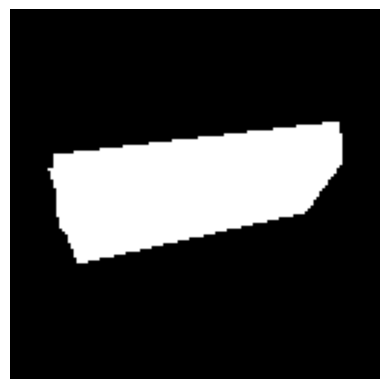

In [66]:
aoi_square_list =  get_squares(aoi)

aoi_land = ee.Geometry.Polygon(aoi[0],None,False)
aoi_square = ee.Geometry.Polygon(aoi_square_list[0],None,False)

ffa_s2_land = ee.ImageCollection('COPERNICUS/S2') \
                        .filterBounds(aoi_land) \
                        .filterDate(ee.Date('2017-01-01'), ee.Date('2023-12-31'))
                        
ffa_s2_square = ee.ImageCollection('COPERNICUS/S2') \
                        .filterBounds(aoi_square) \
                        .filterDate(ee.Date('2017-01-01'), ee.Date('2023-12-31'))

colList_land = ffa_s2_land.toList(30)
colList_square = ffa_s2_land.toList(30)

# LAND -------------------------------------------------------------------------
img_land = ee.Image(colList_land.get(17)).double().clip(aoi_land)
rgb = ['B4','B3','B2']
url_land = img_land.getThumbURL({"min":0, "max":3000,"bands":rgb})

img_data_land = requests.get(url_land).content

path = C_drivePath + 'Sentinel/Z-Aux'
id = img_land.id().getInfo()
with open(path + '/' + id +'.jpg', 'wb') as handler:
  handler.write(img_data_land)

# SQUARE -----------------------------------------------------------------------
img_square = ee.Image(colList_square.get(17)).double().clip(aoi_square)
rgb = ['B4','B3','B2']
url_square = img_square.getThumbURL({"min":0, "max":3000,"bands":rgb})

img_data_square = requests.get(url_square).content

path = C_drivePath + 'Sentinel/Z-Aux'
id = img_square.id().getInfo()
with open(path + '/' + id + '_2' +'.jpg', 'wb') as handler:
 image = handler.write(img_data_square)

disp.Image(url=url_square)

# LOAD IMAGES ------------------------------------------------------------------

name1 = '20170405T112111_20170405T112111_T29TNE.jpg'
img1 = cv2.imread(C_drivePath + 'Sentinel/Z-Aux/' + name1)

img_shape = img1.shape
img_zeros = np.zeros([128, 128, 3])

# from x -> (x+image) = image

img_zeros[39:(39+49), 13:(13+102), :] = img1

cv2.imwrite(C_drivePath + 'Sentinel/Z-Aux/mask.png', img_zeros)

plt.imshow(img_zeros)
plt.axis("off")
plt.show()

#cv2_imshow(img1)

In [74]:
def get_mask(path, aoi, size):
  # Inputs:
  #     - path -> path to the aoi saved images
  #     - aoi -> Area of interest of the landfield
  #     - size = [sizeX, sizeY] -> size of the mask, (ie: 128x128, 256x256, 354x128...)
  ffa_s2 = ee.ImageCollection('COPERNICUS/S2') \
                        .filterBounds(aoi) \
                        .filterDate(ee.Date('2017-01-01'), ee.Date('2023-12-31'))
  colList = ffa_s2.toList(30)
  # This part get's the land area image needed to create the mask --------------
  img = ee.Image(colList.get(17)).double().clip(aoi)
  rgb = ['B4','B3','B2']
  url = img.getThumbURL({"min":20000, "max":20000,"bands":rgb})

  img_data = requests.get(url).content

  path_c = C_drivePath + path
  id = img.id().getInfo()
  with open(path_c + '/mask_aux.jpg', 'wb') as handler:
    handler.write(img_data)

  # load the saved image -------------------------------------------------------
  img_aux = cv2.imread(path_c + '/mask_aux.jpg')
  img_zeros = np.zeros([128, 128, 3])

  # Create mask ----------------------------------------------------------------
  # img_aux.shape -> [x,y,z]
  x = img_aux.shape[0]
  y = img_aux.shape[1]
  x_sum = math.ceil((size-x)/2)
  y_sum = math.ceil((size-y)/2)

  img_zeros = np.zeros([size[0], size[1], 3])
  img_zeros[x_sum:(x_sum+x), y_sum:(y_sum+y), :] = img_aux

  return img_zeros

# TEST ----------------------- (delete) -----------------
name1 = '20170405T112111_20170405T112111_T29TNE.jpg'
img1 = cv2.imread(C_drivePath + 'Sentinel/Z-Aux/' + name1)
aoi_land = ee.Geometry.Polygon(aoi[0],None,False)
img = get_mask(img1, aoi_land, 128)

plt.imshow(img)
plt.axis("off")
plt.show()

UFuncTypeError: ignored

In [ ]:
disp.Image(img1)

# Test

In [ ]:
square_coords = [[[-8.474415606544039, 40.23368990967016],
          [-8.474415606544039, 40.22471245101487],
          [-8.462313479468843, 40.22471245101487],
          [-8.462313479468843, 40.23368990967016]]]

poly = [[[-8.481757943461618, 40.221058298898306],
           [-8.482487504313669, 40.217650300991174],
           [-8.474054639170847, 40.21909216718002],
           [-8.472788636515817, 40.220484849707624],
           [-8.472938840220651, 40.22176281554504]]]

testing_edge = [[[-8.486570903134364, 40.22201669717746],
          [-8.486570903134364, 40.21728156684586],
          [-8.471378871274013, 40.21728156684586],
          [-8.471378871274013, 40.22201669717746]]]
list_testing = []
list_testing.append(testing_edge)
aois_testing = get_squares(list_testing)
test_inside ,new_testingAois = check_if_inside(testing_edge,aois_testing[0])

new_testingGeometry = []
for aoi_test in new_testingAois:
  new_testingGeometry.append(ee.Geometry.Polygon(aoi,None,False))

for idx, aoi_test in enumerate(new_testingGeometry):
  ffa_s2 = ee.ImageCollection('COPERNICUS/S2') \
                        .filterBounds(aoi_test) \
                        .filterDate(ee.Date('2017-01-01'), ee.Date('2023-12-31'))
  colList = ffa_s2.toList(30)


  img = ee.Image(colList.get(17)).double().clip(aoi_test)


  rgb = ['B4','B3','B2']
  url = img.getThumbURL({"min":0, "max":2500,"bands":rgb})

  img_data = requests.get(url).content

  path = C_drivePath + 'Sentinel/Z-Aux/' + str(idx)
  id = img.id().getInfo()
  with open(path + '/' + id +'.jpg', 'wb') as handler:
    handler.write(img_data)

In [ ]:
poly = [[[-8.481757943461618, 40.221058298898306],
           [-8.482487504313669, 40.217650300991174],
           [-8.474054639170847, 40.21909216718002],
           [-8.472788636515817, 40.220484849707624],
           [-8.472938840220651, 40.22176281554504]]]

aois = [poly] 
naois = get_squares(aois)

aoi_test = ee.Geometry.Polygon(aois[0],None,False)


ffa_s2 = ee.ImageCollection('COPERNICUS/S2') \
                       .filterBounds(aoi_test) \
                       .filterDate(ee.Date('2017-01-01'), ee.Date('2023-12-31'))
colList = ffa_s2.toList(30)


img = ee.Image(colList.get(17)).double().clip(aoi_test)


rgb = ['B4','B3','B2']
url = img.getThumbURL({"min":0, "max":2500,"bands":rgb})

img_data = requests.get(url).content

path = C_drivePath + 'Sentinel/Z-Aux'
id = img.id().getInfo()
with open(path + '/' + id +'.jpg', 'wb') as handler:
  handler.write(img_data)


disp.Image(url=url, width = 300)

[1, 1]


Next, we filter the S1 archive to get an image over the _aoi_ acquired sometime in August, 2020. Any old image will do fine, so we won't bother to specify the orbit number or whether we want the ASCENDING or DESCENDING node. If we don't specify the instrument mode or resolution, we get _IW_ (interferometric wide swath) mode and $10\times 10\ m^2$ pixels by default. For convenience we grab both decibel and float versions:

# 128x128 aois

In [ ]:
# for each aoi, get the square and create the new list ee.Geometry.Polygon
aois = get_squares(aoi_list)
aois_geometry = []
for aoi in aois:
  aois_geometry.append(ee.Geometry.Polygon(aoi,None,False))

## SENTINEL-1

In [ ]:
ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD') 
                       .filterBounds(aois_geometry[0]) 
                       .filterDate(ee.Date('2019-01-01'), ee.Date('2019-12-31')) 
                       .first() 
                       .clip(aois_geometry[0]))

# Testing the best range for the bands, min and max

In [ ]:
ffa_db.bandNames().getInfo()

['VV', 'VH', 'angle']

In [ ]:
ffa_s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
                       .filterBounds(aois_geometry[0]) \
                       .filterDate(ee.Date('2019-01-01'), ee.Date('2019-12-31'))
colList = ffa_s1.toList(30)

img = ee.Image(colList.get(19)).double().clip(aois_geometry[0])
url = img.select('VH').getThumbURL({'min': -25, 'max': -7})
disp.Image(url=url, width = 300)

# Function to request the images Sentinel-1 ---------------------------------------------------------------------

In [ ]:
def ExportCol_Sentinel1(path, roi, channel, min, max, n):
  try:
    for i in range(0,nimgs,1):
      ffa_s = ee.ImageCollection('COPERNICUS/S1_GRD') \
                        .filterBounds(roi) \
                        .filterDate(ee.Date(starting_date), ee.Date(ending_date))

      colList = ffa_s.toList(nimgs); 

      img = ee.Image(colList.get(i)).double().clip(roi)
      # Exeption beacause to get a RGB channel with the Sentinel-1 we need to correspond each channel and compute the last
      if channel == 'RGB':
        imgR = img.select('VV')
        imgG = img.select('VH')
        imgB = img.select('VV').divide(img.select('VH'))
        url = ee.Image.rgb(imgR,imgG,imgB).getThumbURL({'min': [min[0], min[1], 0], 'max': [0, 0, 2]})
      else:
        url = img.select(channel).getThumbURL({'min': min[n], 'max': max[n]})

      id = img.id().getInfo()
      img_data = requests.get(url).content

      # Creates the folder but the flag need to be turned off beacause it will try to makedir after the creation
      try:
        os.makedirs(path)
        with open(path + '/' + id +'.jpg', 'wb') as handler:
          handler.write(img_data)
          #create_folders = False
      except:
        # This just saves the image in the correct folder with the name 'id' (var->'id')
        with open(path + '/' + id +'.jpg', 'wb') as handler:
          handler.write(img_data)
  except:
    return

The request

In [ ]:
# Variables needed to save images
bands_s1 = ffa_db.bandNames().getInfo()
bands_s1.remove('angle')
bands_s1.append('RGB')

min = [-14, -25]
max = [-7] * 2
#-------------------
for idx, a in enumerate(aois_geometry):
  for jdx, b in enumerate(bands_s1):
    path = folder_dataset +'/'+ aoi_names[idx] +'/'+ b
    ExportCol_Sentinel1(path, a, b, min, max, jdx)

In [ ]:
# delete
for i, a in enumerate(aois):
  print(i)
  print(' ')
  #print(a)

bands_s1 = ffa_db.bandNames().getInfo()
bands_s1.remove('angle')
bands_s1.append('RGB')

for jdx, b in enumerate(bands_s1):
  print(b)

0
 
VV
VH
RGB


# Test of the RGB image using the 2 channels of the Sentinel-1

In [ ]:
# Make an RGB color composite image (VV,VH,VV/VH).
rgb = ee.Image.rgb(ffa_db.select('VV'),
                   ffa_db.select('VH'),
                   ffa_db.select('VV').divide(ffa_db.select('VH'))).getThumbURL({'min': [-14, -25, 0], 'max': [-7, -7, 3]})


disp.Image(url=rgb, width = 300)

# SENTINEL-2 testing ---------------------------------

In [ ]:
aoi1 = ee.Geometry.Polygon(
        [[[-8.48545509905759, 40.22345971261565],
          [-8.48545509905759, 40.2128095274749],
          [-8.461937490415012, 40.2128095274749],
          [-8.461937490415012, 40.22345971261565]]],None,False)

ffa_db2 = ee.Image(ee.ImageCollection('COPERNICUS/S2') 
                       .filterBounds(aoi1) 
                       .filterDate(ee.Date('2019-01-01'), ee.Date('2019-12-31')) 
                       .first()
                       .clip(aoi1))

ffa_s2 = ee.ImageCollection('COPERNICUS/S2') \
                       .filterBounds(aoi1) \
                       .filterDate(ee.Date('2017-01-01'), ee.Date('2023-12-31'))
colList = ffa_s2.toList(30)


img = ee.Image(colList.get(18)).double().clip(aoi1)

rgb = ['B12']
url = img.getThumbURL({"min":0, "max":2500,"bands":rgb})

disp.Image(url=url, width = 300)

In [ ]:
aoi1 = ee.Geometry.Polygon(
         [[[-8.471299278632037, 40.22244132271391],
          [-8.471299278632037, 40.215199270092846],
          [-8.460098373785845, 40.215199270092846],
          [-8.460098373785845, 40.22244132271391]]],None,False)

ffa_db2 = ee.Image(ee.ImageCollection('COPERNICUS/S2') 
                       .filterBounds(aoi1) 
                       .filterDate(ee.Date('2019-01-01'), ee.Date('2019-12-31')) 
                       .first()
                       .clip(aoi1))

ffa_s2 = ee.ImageCollection('COPERNICUS/S2') \
                       .filterBounds(aoi1) \
                       .filterDate(ee.Date('2017-01-01'), ee.Date('2023-12-31'))
colList = ffa_s2.toList(30)


img = ee.Image(colList.get(18)).double().clip(aoi1)

rgb = ['B4','B3','B2']
url = img.getThumbURL({"min":0, "max":2500,"bands":rgb})

disp.Image(url=url, width = 300)

In [ ]:
ffa_db2.bandNames().getInfo()

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B10',
 'B11',
 'B12',
 'QA10',
 'QA20',
 'QA60']

In [ ]:
rgb = ['B4','B3','B2']
url = ffa_db2.getThumbURL({"min":0, "max":2500,"bands":rgb})

disp.Image(url=url, width = 300)

In [ ]:
ffa_s2 = ee.ImageCollection('COPERNICUS/S2') \
                       .filterBounds(aoi1) \
                       .filterDate(ee.Date('2017-01-01'), ee.Date('2023-12-31'))
colList = ffa_s2.toList(10)

# Sentinel-2 request fucntion

In [ ]:
def ExportCol_Sentinel2(folder, roi, roi_name channel, create_folders, min, max, n):
  for i in range(0,nimgs,1):
    try:
      ffa_s = ee.ImageCollection('COPERNICUS/S2') \
                        .filterBounds(roi) \
                        .filterDate(ee.Date(starting_date), ee.Date(ending_date))

      colList = ffa_s.toList(ffa_s.size());                   

      img = ee.Image(colList.get(i)).double().clip(roi)
      # Exeption beacause to get a RGB channel with the Sentinel-1 we need to correspond each channel and compute the last
      if channel == 'RGB':
        rgb = ['B4','B3','B2']
        url = img.getThumbURL({"min":min[n], "max":max[n],"bands":rgb})
      else:
        url = img.getThumbURL({"min":min[n], "max":max[n],"bands":channel})

      id = img.id().getInfo()
      img_data = requests.get(url).content
      path = 'drive/MyDrive/' + folder

      # Creates the folder but the flag need to be turned off beacause it will try to makedir after the creation
      if create_folders:
        os.makedirs(path)
        with open(path + '/' + id +'.jpg', 'wb') as handler:
          handler.write(img_data)
          create_folders = False
      else:
        # This just saves the image in the correct folder with the name 'id' (var->'id')
        with open(path + '/' + id +'.jpg', 'wb') as handler:
          handler.write(img_data)
    except:
      return

Request

In [ ]:
bands_s2 = ffa_db2.bandNames().getInfo()
aux_bands_s2 =  bands_s2.copy();
for x in aux_bands_s2: 
  if x in  ['QA10','QA20','QA60','B10']: 
    bands_s2.remove(x) #bands_s2.remove(['QA10','QA20','QA60','B10'])
bands_s2.append('RGB')

min = [0] * len(bands_s2)
max = [2700, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 2000, 3200, 2500, 3000]

bands_s2 = ['RGB']
for a in aois:
  for i in range(0,len(bands_s2),1):
    channel = bands_s2[i]
    folder = 'Sentinel-2/Maize/'+ channel

    ExportCol_Sentinel2(folder, a, channel, create_folders, min, max, 12)

# Testing the best range for the bands, min and max, Sentinel-2

In [ ]:
aoi_test = ee.Geometry.Polygon(
        [[[-8.55251498879442, 40.24180169042327],
          [-8.55251498879442, 40.208117730174855],
          [-8.451578099145982, 40.208117730174855],
          [-8.451578099145982, 40.24180169042327]]],None,False)

ffa_s2_test = ee.ImageCollection('COPERNICUS/S2') \
                       .filterBounds(aoi_test) \
                       .filterDate(ee.Date('2019-01-01'), ee.Date('2019-12-31'))
colList = ffa_s2.toList(10)

ffa_db2_test = ee.Image(ee.ImageCollection('COPERNICUS/S2') 
                       .filterBounds(aoi_test) 
                       .filterDate(ee.Date('2019-01-01'), ee.Date('2019-12-31')) 
                       .first()
                       .clip(aoi_test))

img = ee.Image(colList.get(0)).double().clip(aoi_test)

#rgb = ['B4','B3','B2']
#url = ffa_db2_test.getThumbURL({"min":0, "max":3000,"bands":rgb})

url = img.select('QA60').getThumbURL({'min': -50, 'max': 50})
disp.Image(url=url, width = 700)

In [ ]:
bands_s2 = ffa_db2.bandNames().getInfo()
aux =  bands_s2.copy();
for x in aux:
  if x in ['QA20','QA10','QA60','B10']:
    bands_s2.remove(x) #bands_s2.remove(['QA10','QA20','QA60','B10'])
bands_s2.append('RGB')

min = [0] * len(bands_s2)
max = [2700, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 2000, 3200, 2500, 3000]
print(len(max))
print(len(min))
print(bands_s2)

13
13
['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'RGB']


In [ ]:
ffa_s = ee.ImageCollection('COPERNICUS/S1_GRD') \
                       .filterBounds(aoi1) \
                       .filterDate(ee.Date('2022-01-07'), ee.Date('2022-04-07'))

colList = ffa_s.toList(ffa_s.size());       

i = 1330
img = ee.Image(colList.get(i)).double().clip(aoi1)

#id = img.id().getInfo()

